In [1]:
# %%
import ot
import numpy as np
import otmol as otm
import pandas as pd
from openbabel import pybel
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import os
# %matplotlib widget

In [22]:
def RMSD(V, W):
    """ 
    Calculate Root-mean-square deviation from two sets of vectors V and W.
    """
    N = V.shape[0]
    return np.sqrt(np.sum((V-W)**2)/N)

def compare_lists(list1, list2):
    """
    Compare two lists and return the indices and elements where they differ.

    Args:
        list1 (list): The first list to compare.
        list2 (list): The second list to compare.

    Returns:
        list: A list of tuples, where each tuple contains the index and the differing elements
              in the format (index, element_from_list1, element_from_list2).
    """
    differences = []
    # Compare elements up to the length of the shorter list
    for i in range(len(list1)):
        if list1[i] != list2[i]:
            differences.append((i, list1[i], list2[i]))

    return differences

def parse_molecule_pairs(file_path, mol_type: str = 'water cluster'):
    """
    Parses a file containing molecule pairs separated by an underscore ('_').

    Parameters:
    ----------
    file_path : str
        Path to the file containing molecule pairs.

    Returns:
    -------
    list of lists
        A list where each element is a pair [molA, molB].
    """
    molecule_pairs = []
    with open(file_path, 'r') as file:
        if mol_type == 'water cluster' or mol_type == 'S1':
            for line in file:
                line = line.strip()  # Remove any leading/trailing whitespace
                if line:  # Skip empty lines
                    # Some lines are like "molA_molB_2", and some are like "molA_molB"
                    molecule_pairs.append([line.split('_')[0], line.split('_')[1]])
        if mol_type == 'FGG':
            next(file)  # Skip the first line
            for line in file:
                line = line.strip()
                if line:
                    molA, molB = line.split('-')
                    molecule_pairs.append([molA, molB])
    return molecule_pairs

def cost_matrix(T_A: list = None, T_B: list = None, k = 1e11):
    n = len(T_A)
    m = len(T_B)
    C = np.zeros((n, m), dtype=float)
    for i in range(n):
        for j in range(m):
            if  T_A[i] == T_B[j]:
                C[i, j] = 0
            else:
                C[i, j] = k
    return C

def parse_xyz(file_path):
    """
    Parse an XYZ file to extract atom name, SYBYL atom type, or atom connectivity and coordinates.

    Args:
        file_path (str): Path to the XYZ file.

    Returns:
        tuple: Two lists - one with desired atom category and another with coordinates.
    """
    atom_types = []
    coordinates = []

    with open(file_path, 'r') as file:
        lines = file.readlines()

        # Skip the first two lines (number of atoms and comment line)
        for line in lines[2:]:
            parts = line.strip().split()
            if len(parts) >= 4:
                atom_types.append(parts[0])  # First column is the SYBYL atom type
                coordinates.append([float(parts[1]), float(parts[2]), float(parts[3])])  # Next three columns are coordinates

    return np.array(coordinates, dtype=float), np.array(atom_types, dtype=str) 

In [33]:
def Experiment(data_path: str = None,mol_pair: list = None, method: str = 'fgw', 
               alpha_list: list = None, D_matrix: str = 'geodesic', p_list: list = None,
               setup: str = 'atom name'
               ):
    """
    Experiment with ArbAlign data.
    """
    results = []
    # Load the molecule pairs from the specified file
    for nameA, nameB in mol_pair:
        if setup == 'atom name':
            molA = next(pybel.readfile('xyz', os.path.join(data_path, nameA + '.xyz')))
            molB = next(pybel.readfile('xyz', os.path.join(data_path, nameB + '.xyz')))
            # Basic processing of the molecules
            X_A, T_A, B_A = otm.tl.process_molecule(molA) # Output (1) spatial coordinates, (2) atom types, and (3) bonds as numpy arrays.
            X_B, T_B, B_B = otm.tl.process_molecule(molB)
        # Compute the distance matrices
            C = otm.tl.molecule_physchem_distance(T_A, T_B)
            C = np.where(C>0, 1e12, C)
            #D_A = otm.tl.geodesic_distance(X_A, B_A)
            #D_B = otm.tl.geodesic_distance(X_B, B_B)
        if setup == 'atom type':
            X_A, T_A = parse_xyz(os.path.join(data_path, 't-'+ nameA + '.xyz'))
            X_B, T_B = parse_xyz(os.path.join(data_path, 't-'+ nameB + '.xyz'))
            C = cost_matrix(T_A, T_B, 1e12)
        if setup == 'atom connectivity':
            X_A, T_A = parse_xyz(os.path.join(data_path, 'c-'+ nameA + '.xyz'))
            X_B, T_B = parse_xyz(os.path.join(data_path, 'c-'+ nameB + '.xyz'))
            C = cost_matrix(T_A, T_B, 1e12)
        D_A = distance_matrix(X_A, X_A)
        D_B = distance_matrix(X_B, X_B)
        rmsd_best = 1e10
        p_best = None
        P_best = None
        alpha_best = None
        if method == 'fgw':
        # Fused Gromov-Wasserstein
            for alpha in alpha_list:
                for p in p_list:
                    #if D_matrix == 'geodesic':
                    #    P = otm.tl.molecule_optimal_transport(C, D_A**p, D_B**p, method=method, alpha=alpha)
                    if D_matrix == 'euclidean':
                        P = otm.tl.molecule_optimal_transport(C, D_A**p, D_B**p, method=method, alpha=alpha)
                    X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, P)
                    rmsd = RMSD(X_A, X_B_aligned[np.argmax(P, axis=1)])
                    if rmsd < rmsd_best:
                        rmsd_best = rmsd
                        p_best = p
                        P_best = P
                        alpha_best = alpha
            optimal_assignment = np.argmax(P_best, axis=1)
            
        if len(np.unique(optimal_assignment)) != X_A.shape[0]: # check if the assignment is 1 to 1
            print(nameA, nameB, 'Warning: the assignment is not 1 to 1')
        if compare_lists(T_A, T_B[optimal_assignment]): # check if atom names are matched
            print(nameA, nameB, 'Warning: unmatched {} exists'.format(setup))
        results.append({
            'nameA': nameA,
            'nameB': nameB,
            'RMSD(otmol+{})'.format(setup): rmsd_best,
            '# atoms': X_A.shape[0],
            'alpha': alpha_best,
            'p': p_best,
            'assignment': optimal_assignment,
            #'atomname_diff': compare_lists(T_A, T_B[optimal_assignment])
        }) 
        print(nameA, nameB, rmsd_best)

    return pd.DataFrame(results)

In [31]:
import subprocess
data_path = "./DataArbAlign/FGG-Tripeptide"
mol_pair_list_path = os.path.join(data_path, 'list')
molecule_pairs = parse_molecule_pairs(mol_pair_list_path, mol_type='FGG')
for nameA, nameB in molecule_pairs:
    subprocess.run(['zsh', 'AtomTypes.zsh', nameA + '.xyz', data_path])
    subprocess.run(['zsh', 'AtomTypes.zsh', nameB + '.xyz', data_path])
    subprocess.run(['zsh', 'AtomConn.zsh', nameA + '.xyz', data_path])
    subprocess.run(['zsh', 'AtomConn.zsh', nameB + '.xyz', data_path])

1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule co

In [35]:
otmol_name_res = Experiment(data_path, molecule_pairs, setup='atom name', method='fgw', D_matrix='euclidean', alpha_list=np.linspace(0,0.1,1000), p_list=[0.5,1,2])
otmol_type_res = Experiment(data_path, molecule_pairs, setup='atom type', method='fgw', D_matrix='euclidean', alpha_list=np.linspace(0,0.1,1000), p_list=[0.5,1,2])
otmol_conn_res = Experiment(data_path, molecule_pairs, setup='atom connectivity', method='fgw', D_matrix='euclidean', alpha_list=np.linspace(0,0.1,1000), p_list=[0.5,1,2])

252_FGG55 253_FGG99 1.7876994032557443
252_FGG55 254_FGG300 1.9404307123173092
252_FGG55 255_FGG252 2.030183890671386
252_FGG55 256_FGG366 2.293084610348439
252_FGG55 257_FGG215 1.49818967623898
252_FGG55 258_FGG224 0.7462840440918397
252_FGG55 259_FGG380 1.2754148103268519
252_FGG55 260_FGG412 1.6950179526579114
252_FGG55 261_FGG444 1.1422673356214297
252_FGG55 262_FGG470 1.3469703904831836
252_FGG55 263_FGG80 1.5382304895192618
252_FGG55 264_FGG114 1.5439659584903764
252_FGG55 265_FGG357 1.5867602989661076
252_FGG55 266_FGG691 2.1822439707012604
252_FGG55 253_FGG99 1.8419474720732567
252_FGG55 254_FGG300 2.057167387726446
252_FGG55 255_FGG252 2.1397976679857282
252_FGG55 256_FGG366 2.4131944903419678
252_FGG55 257_FGG215 1.49818967623898
252_FGG55 258_FGG224 0.7462840440918397
252_FGG55 259_FGG380 1.3224685098464506
252_FGG55 260_FGG412 1.7854742258624845
252_FGG55 261_FGG444 1.1422673356214297
252_FGG55 262_FGG470 1.309505149899044
252_FGG55 263_FGG80 1.5594302208103286
252_FGG55 26

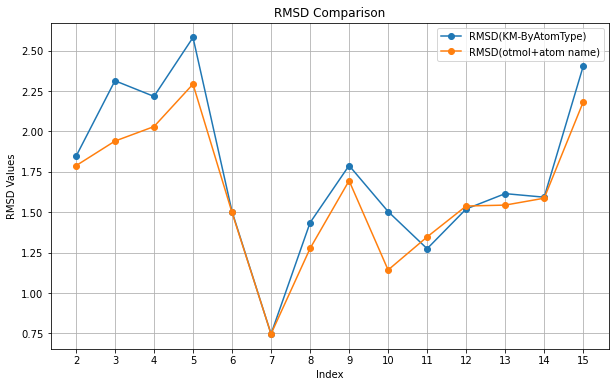

In [36]:
# Concatenate otmol_res and df along the columns
arbalign_res = pd.read_csv(os.path.join(data_path, 'rmsd-2017.dat'), sep='\s+')
combined_df = pd.concat([arbalign_res, otmol_name_res, otmol_type_res, otmol_conn_res], axis=1)
# Plot the specified columns against the Index column
columns_to_plot = ["RMSD(KM-ByAtomType)", "RMSD(otmol+atom name)"]
#"RMSD(KM-ByAtomType)", "RMSD(KM-byAtomConn)", 
plt.figure(figsize=(10,6))
# Plot each column against the Index column
for column in columns_to_plot:
    plt.plot(range(2,16), combined_df[column], marker='o', label=column)
plt.title("RMSD Comparison")
plt.xlabel("Index")
plt.ylabel("RMSD Values")
#plt.ylim(0.5, 3)
plt.xticks(range(2,16))
plt.legend()
plt.grid(True)

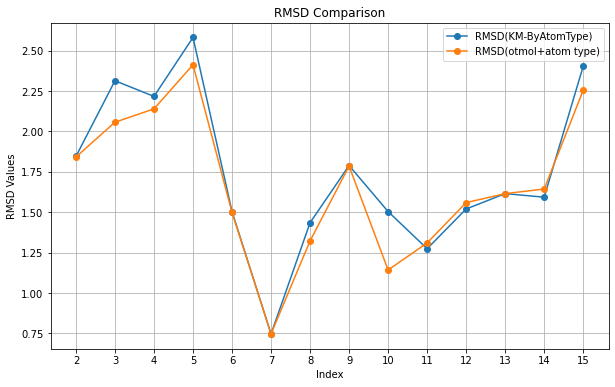

In [37]:
columns_to_plot = ["RMSD(KM-ByAtomType)", "RMSD(otmol+atom type)"]
#"RMSD(KM-ByAtomType)", "RMSD(KM-byAtomConn)", 
plt.figure(figsize=(10,6))
# Plot each column against the Index column
for column in columns_to_plot:
    plt.plot(range(2,16), combined_df[column], marker='o', label=column)
plt.title("RMSD Comparison")
plt.xlabel("Index")
plt.ylabel("RMSD Values")
#plt.ylim(0.5, 3)
plt.xticks(range(2,16))
plt.legend()
plt.grid(True)

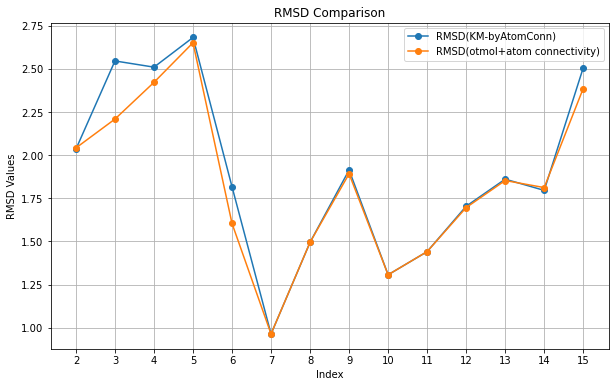

In [39]:
columns_to_plot = ["RMSD(KM-byAtomConn)", "RMSD(otmol+atom connectivity)"]
#"RMSD(KM-ByAtomType)", "RMSD(KM-byAtomConn)", 
plt.figure(figsize=(10,6))
# Plot each column against the Index column
for column in columns_to_plot:
    plt.plot(range(2,16), combined_df[column], marker='o', label=column)
plt.title("RMSD Comparison")
plt.xlabel("Index")
plt.ylabel("RMSD Values")
#plt.ylim(0.5, 3)
plt.xticks(range(2,16))
plt.legend()
plt.grid(True)

In [9]:
"""
data_path = "./DataArbAlign/S1-MA-W1"
#data_path = "./DataArbAlign/FGG"
mol_pair_list_path = os.path.join(data_path, 'list')
molecule_pairs = parse_molecule_pairs(mol_pair_list_path, mol_type='S1')
Experiment(molecule_pairs, method='fgw', alpha=0.4)"
"""

'\ndata_path = "./DataArbAlign/S1-MA-W1"\n#data_path = "./DataArbAlign/FGG"\nmol_pair_list_path = os.path.join(data_path, \'list\')\nmolecule_pairs = parse_molecule_pairs(mol_pair_list_path, mol_type=\'S1\')\nExperiment(molecule_pairs, method=\'fgw\', alpha=0.4)"\n'

In [10]:
# %%
# Read the molecules
molA = next(pybel.readfile("xyz", "./DataArbAlign/FGG-Tripeptide/252_FGG55.xyz"))
molB = next(pybel.readfile("xyz", "./DataArbAlign/FGG-Tripeptide/253_FGG99.xyz"))
#molA = next(pybel.readfile("xyz", "./DataArbAlign/S1-MA-W1/s1maw1-1.xyz"))

1.7876994032557443
['O' 'C' 'O' 'H' 'C' 'H' 'H' 'N' 'H' 'C' 'O' 'C' 'H' 'H' 'N' 'H' 'C' 'O'
 'C' 'N' 'H' 'H' 'H' 'C' 'H' 'H' 'C' 'C' 'H' 'C' 'H' 'C' 'H' 'C' 'H' 'C'
 'H']
['O' 'C' 'O' 'H' 'C' 'H' 'H' 'N' 'H' 'C' 'O' 'C' 'H' 'H' 'N' 'H' 'C' 'O'
 'C' 'N' 'H' 'H' 'H' 'C' 'H' 'H' 'C' 'C' 'H' 'C' 'H' 'C' 'H' 'C' 'H' 'C'
 'H']
[]


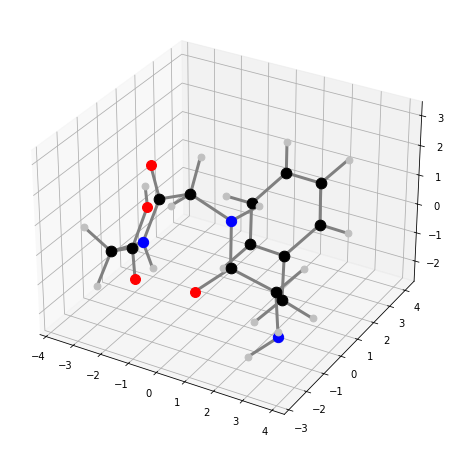

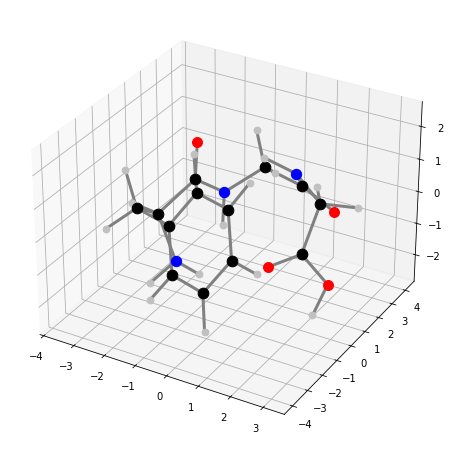

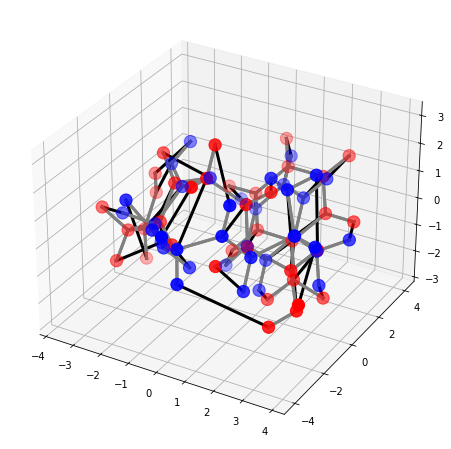

In [11]:
# %%
def permutation_to_matrix(permutation):
    """
    Converts a permutation list to a permutation matrix.
    
    Args:
        permutation (list or array): A list or array representing the permutation.
                                     For example, [2, 0, 1] means index 0 maps to 2, index 1 maps to 0, etc.
    
    Returns:
        numpy.ndarray: A permutation matrix.
    """
    n = len(permutation)
    matrix = np.zeros((n, n), dtype=int)
    for i, j in enumerate(permutation):
        matrix[i, j] = 1
    return matrix
# Basic processing of the molecules
X_A, T_A, B_A = otm.tl.process_molecule(molA) # Output (1) spatial coordinates, (2) atom types, and (3) bonds as numpy arrays.
X_B, T_B, B_B = otm.tl.process_molecule(molB)
otm.pl.plot_molecule(X_A, T_A, B_A, coloring = 'type', sizing = 'type')
otm.pl.plot_molecule(X_B, T_B, B_B, coloring = 'type', sizing = 'type')
P = permutation_to_matrix(otmol_res['assignment'][0])
X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, P) 
print(RMSD(X_A, X_B_aligned[np.argmax(P, axis=1)]))
print(T_A)
print(T_B[np.argmax(P, axis=1)])
print(compare_lists(T_A, T_B[np.argmax(P, axis=1)]))
otm.pl.plot_alignment(X_A, X_B_aligned, B_A, B_B, P, weight_cutoff=0.01)
plt.show()


In [12]:
# %%
C = otm.tl.molecule_physchem_distance(T_A, T_B)
D_A = otm.tl.geodesic_distance(X_A, B_A)
D_B = otm.tl.geodesic_distance(X_B, B_B)

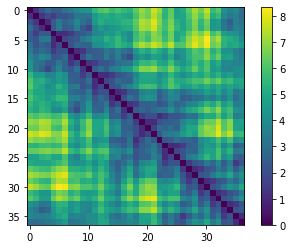

In [13]:
# %%
# Fused Gromov-Wasserstein
DD_A = distance_matrix(X_A, X_A)
DD_B = distance_matrix(X_B, X_B)
P = otm.tl.molecule_optimal_transport(C, D_A+17*DD_A, D_B+17*DD_B, method='fgw', alpha=0.1)
plt.show()
plt.imshow(DD_A)
plt.colorbar()

2.4043992558309104
[(0, 'O', 'H'), (5, 'H', 'O'), (8, 'H', 'C'), (9, 'C', 'H'), (14, 'N', 'C'), (17, 'O', 'N'), (18, 'C', 'H'), (19, 'N', 'C'), (23, 'C', 'N'), (25, 'H', 'O')]


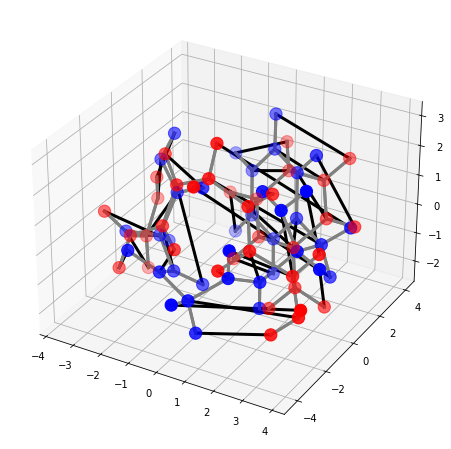

In [14]:
X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, P) 
print(RMSD(X_A, X_B_aligned[np.argmax(P, axis=1)]))
print(compare_lists(T_A, T_B[np.argmax(P, axis=1)]))
otm.pl.plot_alignment(X_A, X_B_aligned, B_A, B_B, P, weight_cutoff=0.01)
plt.show()

2.237235753083236


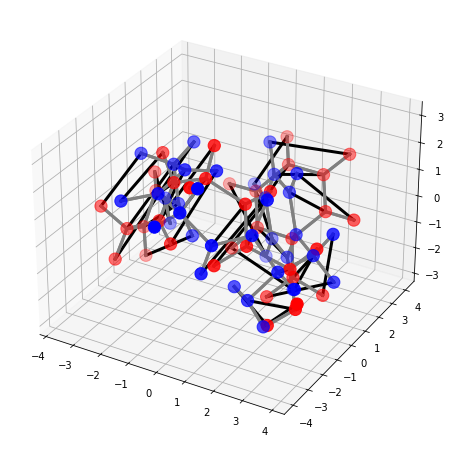

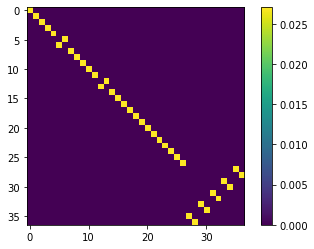

In [15]:
# %%
# Gromov-Wasserstein
P = otm.tl.molecule_optimal_transport(C, D_A, D_B, method='gw', alpha=0.9)
X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, P)
otm.pl.plot_alignment(X_A, X_B_aligned, B_A, B_B, P)
print(RMSD(X_A, X_B_aligned[np.argmax(P, axis=1)]))
plt.show()
plt.imshow(P)
plt.colorbar()


No more edges in the graph.
2.1552160380660763


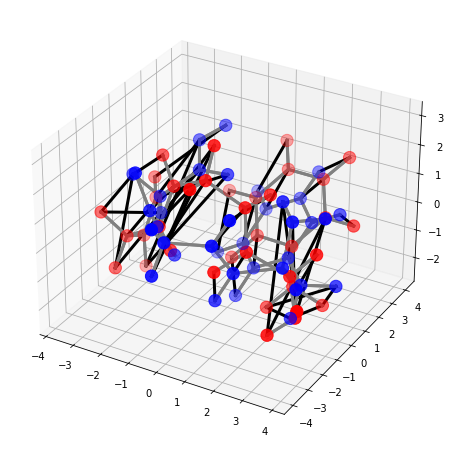

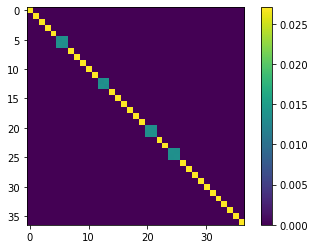

In [16]:
# %%
# Supervised Gromov-Wasserstein
P = otm.tl.molecule_optimal_transport(C, D_A, D_B, method='sgw', sgw_cutoff=5)
X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, P)
otm.pl.plot_alignment(X_A, X_B_aligned, B_A, B_B, P)
print(RMSD(X_A, X_B_aligned[np.argmax(P, axis=1)]))
plt.show()
plt.imshow(P)
plt.colorbar()

# of potential non-zeros in P: 210
2.1552260859951216
[]


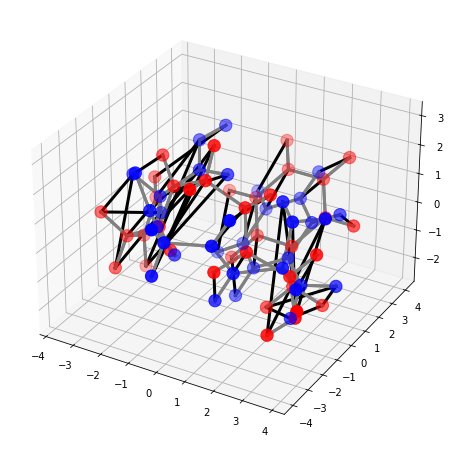

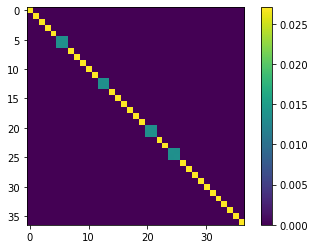

In [17]:
# %%
# Fused supervised Gromov-Wasserstein
P = otm.tl.molecule_optimal_transport(C, D_A, D_B, method='fsgw', sgw_cutoff=5, alpha=0.5)
X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, P)
otm.pl.plot_alignment(X_A, X_B_aligned, B_A, B_B, P)
print(RMSD(X_A, X_B_aligned[np.argmax(P, axis=1)]))
print(compare_lists(T_A, T_B[np.argmax(P, axis=1)]))
plt.show()
plt.imshow(P)
plt.colorbar()